In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interpn
import os
import glob
import random

import config
import utils


In [2]:
from keras.models import Model
from keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, UpSampling2D, Input, concatenate, Activation,LeakyReLU
from keras import backend as K
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, SGD


Using TensorFlow backend.


In [3]:
# Read all simulated profiles for a regular grid of primary beam parameters, for fields 3x3, 10x10, and 30x30

dataPoints = [(str(e),str(se),str(s),str(an)) for e in config.simulatedEnergies for se in config.simulatedEnergyDispersions for s in config.simulatedSourceSizes 
              for an in config.simulatedAngularDivergences]

random.seed(config.SEED)
random.shuffle(dataPoints)

profiles = utils.readProfiles(config.profileDIR,dataPoints)

profiles = np.asarray(profiles)
goals = np.asarray(dataPoints,dtype=np.float)

print(profiles.shape,goals.shape)

(3, 300, 6, 495) (300, 4)


In [4]:
#profiles.shape = (3, 300, 6, 495)
#analyzedProfiles = [None,[0,3],[1,3]]

inp1 = profiles[1,:,0,config.analyzedRanges[1][0][0]:config.analyzedRanges[1][0][1]]
inp1 = np.reshape(inp1,inp1.shape + (1,))
print(inp1.shape)
inp2 = profiles[1,:,1,config.analyzedRanges[1][1][0]:config.analyzedRanges[1][1][1]]
inp2 = np.reshape(inp2,inp2.shape + (1,))
print(inp2.shape)
inp3 = profiles[1,:,3,config.analyzedRanges[1][2][0]:config.analyzedRanges[1][2][1]]
inp3 = np.reshape(inp3,inp3.shape + (1,))
print(inp3.shape)
inp4 = profiles[2,:,0,config.analyzedRanges[2][0][0]:config.analyzedRanges[2][0][1]]
inp4 = np.reshape(inp4,inp4.shape + (1,))
print(inp4.shape)
inp5 = profiles[2,:,1,config.analyzedRanges[2][1][0]:config.analyzedRanges[2][1][1]]
inp5 = np.reshape(inp5,inp5.shape + (1,))
print(inp5.shape)
inp6 = profiles[2,:,3,config.analyzedRanges[2][2][0]:config.analyzedRanges[2][2][1]]
inp6 = np.reshape(inp6,inp6.shape + (1,))
print(inp6.shape)

(300, 298, 1)
(300, 163, 1)
(300, 177, 1)
(300, 297, 1)
(300, 365, 1)
(300, 395, 1)


In [5]:
from keras.layers import Conv1D,MaxPooling1D,Concatenate,Flatten,Dense

def conv_block(inp,filters=16,kernel_size=3,strides = 1,kernel_initializer= 'glorot_uniform',padding='same',activation='relu'):
    c = Conv1D(filters,kernel_size,kernel_initializer=kernel_initializer,padding=padding,activation=activation,strides = strides)(inp)
    c = Conv1D(filters,kernel_size,kernel_initializer=kernel_initializer,padding=padding,activation=activation,strides = strides)(c)
    c = MaxPooling1D(2)(c)
    return c

inputs = []
outputs = []
for nmod in range(len(config.allRanges)):
    shape = (config.allRanges[nmod][1]-config.allRanges[nmod][0],1)
    print(shape)
    W = int(np.log(shape[0]/3)/np.log(2))
    inp = Input(shape)
    F = 16
    x = inp
    for w in range(W):
        x = conv_block(x,filters = F)
#        x = Conv1D(F,3,activation='relu',padding = 'same') (x)
#        x = Conv1D(F,3,activation='relu',padding = 'same') (x)
#        x = Conv1D(F,3,activation='relu',strides=2) (x)
#        x = MaxPooling1D(2)(x)
        F *= 2
    out = Conv1D(1,1) (x)
    inputs.append(inp)
    outputs.append(out)

c = Concatenate(axis=1)(outputs)
c = Flatten()(c)
c = Dense(100,activation='relu')(c)
c = Dense(100,activation='relu')(c)
out = Dense(4,activation=None)(c)

model = Model(inputs = inputs,outputs=[out])
#model.summary()

(298, 1)
(163, 1)
(177, 1)
(297, 1)
(365, 1)
(395, 1)


In [6]:
model_filename = 'regresja3.h5'

callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True
)

model.compile(
    optimizer=Adam(lr=0.0001), 
    loss = 'mse',
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)


In [11]:
history = model.fit(
    [inp1,inp2,inp3,inp4,inp5,inp6],goals,
    steps_per_epoch=100,
    epochs=300,
    validation_split=0.2,
    validation_steps = 10,
    callbacks=[callback_checkpoint]
)

In [7]:
#Run if the trained model already exists

model.load_weights('regresja3.h5')

In [8]:
groundTruthFilename = config.testProfilesDIR + config.groundTruthFileName

testGoals = open(groundTruthFilename)
lines = testGoals.readlines()
y_test = [l[:-1].split()[1:5] for l in lines[:-1]]
fileNames = [l[:-1].split()[0] for l in lines[:-1]]
testGoals.close()

fields = ['fields','fields10','fields30']
testProfiles3 = []
testProfiles10 = []
testProfiles30 = []

for fileName in fileNames:
    name = config.testProfilesDIR + fileName + '_' + fields[0] + '.npz'
    file = np.load(name)
    testProfiles3.append(file[file.files[1]])

    name = config.testProfilesDIR + fileName + '_' + fields[1] + '.npz'
    file = np.load(name)
    testProfiles10.append(file[file.files[1]])

    name = config.testProfilesDIR + fileName + '_' + fields[2] + '.npz'
    file = np.load(name)
    testProfiles30.append(file[file.files[1]])
        

testProfiles = []
testProfiles.append(testProfiles3)
testProfiles.append(testProfiles10)
testProfiles.append(testProfiles30)

testProfiles = np.asarray(testProfiles,dtype=np.float)
y_test = np.asarray(y_test,dtype=np.float)

print(testProfiles.shape,y_test.shape)

(3, 25, 6, 495) (25, 4)


In [9]:
testInp1 = testProfiles[1,:,0,config.analyzedRanges[1][0][0]:config.analyzedRanges[1][0][1]]
testInp1 = np.reshape(testInp1,testInp1.shape + (1,))
print(testInp1.shape)
testInp2 = testProfiles[1,:,1,config.analyzedRanges[1][1][0]:config.analyzedRanges[1][1][1]]
testInp2 = np.reshape(testInp2,testInp2.shape + (1,))
print(testInp2.shape)
testInp3 = testProfiles[1,:,3,config.analyzedRanges[1][2][0]:config.analyzedRanges[1][2][1]]
testInp3 = np.reshape(testInp3,testInp3.shape + (1,))
print(testInp3.shape)
testInp4 = testProfiles[2,:,0,config.analyzedRanges[2][0][0]:config.analyzedRanges[2][0][1]]
testInp4 = np.reshape(testInp4,testInp4.shape + (1,))
print(testInp4.shape)
testInp5 = testProfiles[2,:,1,config.analyzedRanges[2][1][0]:config.analyzedRanges[2][1][1]]
testInp5 = np.reshape(testInp5,testInp5.shape + (1,))
print(testInp5.shape)
testInp6 = testProfiles[2,:,3,config.analyzedRanges[2][2][0]:config.analyzedRanges[2][2][1]]
testInp6 = np.reshape(testInp6,testInp6.shape + (1,))
print(testInp6.shape)

(25, 298, 1)
(25, 163, 1)
(25, 177, 1)
(25, 297, 1)
(25, 365, 1)
(25, 395, 1)


In [10]:
y_predicted = model.predict([testInp1,testInp2,testInp3,testInp4,testInp5,testInp6])
print(y_predicted.shape)
print(type(y_test[0,0]))

(25, 4)
<class 'numpy.float64'>


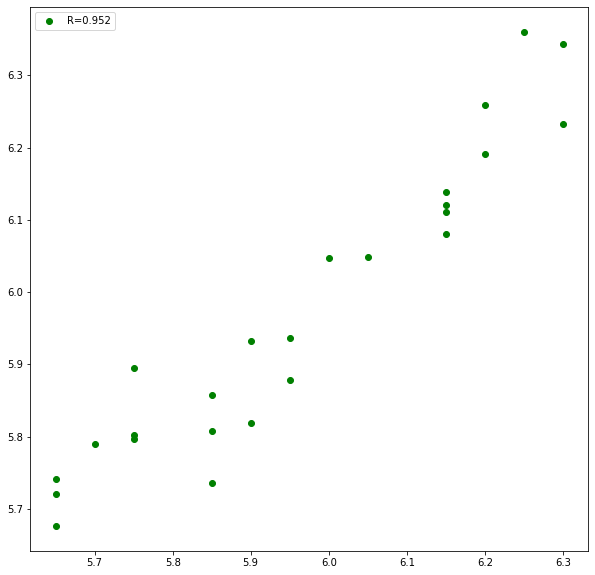

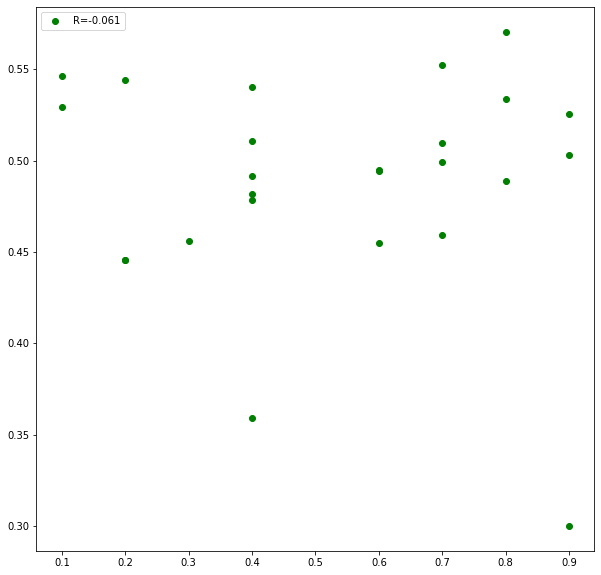

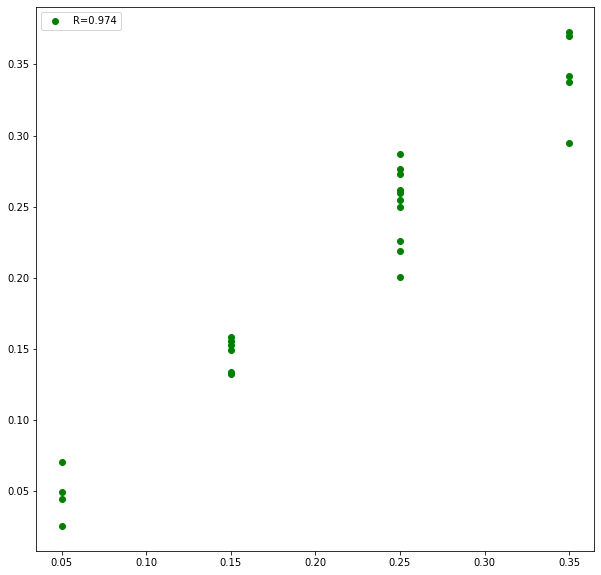

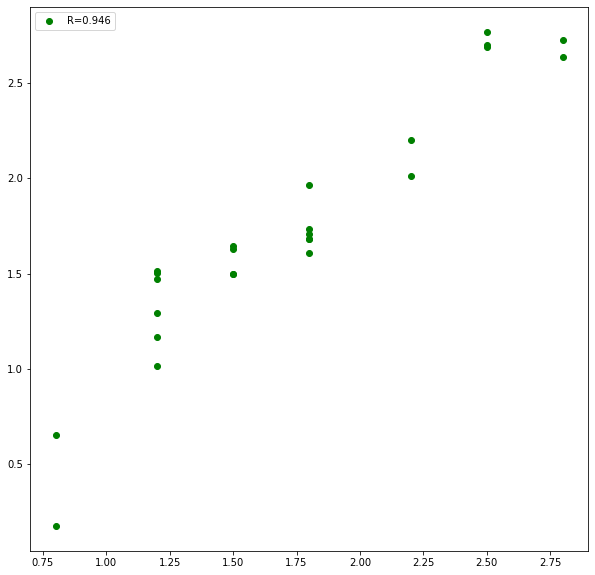

In [11]:
from scipy.stats import pearsonr

for par in range(4):
    plt.figure(figsize=(10,10))
    corr, _ = pearsonr(y_test[:,par], y_predicted[:,par])
    plt.plot(y_test[:,par],y_predicted[:,par],'og',label='R='+str(np.round(corr,3)))
    plt.legend(loc='upper left')
    plt.show()

In [12]:
print(np.std(y_test - y_predicted,0))


[0.06477521 0.26389114 0.02258166 0.20771575]


In [13]:
# Read measured profiles

measuredDoseFiles10 = ['./Measured/Method3/PDD1_10x10.dat','./Measured/Method3/PDD2_10x10.dat',
                       './Measured/Method3/PROF1_10x10_14mm.dat','./Measured/Method3/PROF2_10x10_14mm.dat',
                       './Measured/Method3/PROF1_10x10_100mm.dat','./Measured/Method3/PROF2_10x10_100mm.dat']

measuredDoseFiles30 = ['./Measured/Method3/PDD1_30x30.dat',
                       './Measured/Method3/PROF1_30x30_14mm.dat','./Measured/Method3/PROF2_30x30_14mm.dat',
                       './Measured/Method3/PROF1_30x30_100mm.dat','./Measured/Method3/PROF2_30x30_100mm.dat']


clinicalProfiles = []

xStart = [0,0,-8.1,-8.1,-8.8,-8.8]
profiles = []
for n, measuredDoseFile in enumerate(measuredDoseFiles10):
    f = open(measuredDoseFile)
    lines = f.readlines()
    f.close()
    x = np.asarray([l.split() for l in lines[:-1]],dtype=np.float)
    x[:,0] = x[:,0]/10.
    interpRange = np.arange(xStart[n],x[x.shape[0]-1,0]+config.spaceStep/2,config.spaceStep)
    profile = interpn((x[:,0],),x[:,1] , interpRange)
    print(profile.shape,interpRange.shape,profile[0],profile[profile.shape[0]-1],interpRange[0],interpRange[interpRange.shape[0]-1])
    profiles.append(profile)

dum =np.zeros(config.numOfSimulatedProfileSamples,dtype=np.float)
np.copyto(dum[config.analyzedRanges[1][0][0]:config.analyzedRanges[1][0][1]],(profiles[0][3:]+profiles[1][3:])*0.5)
scale = dum[12]
dum = dum*100.0/scale
clinicalProfiles.append(dum[config.analyzedRanges[1][0][0]:config.analyzedRanges[1][0][1]])                        #Field 10x10 depth profile from 0.3 to 30.0 (both included)

dum =np.zeros(config.numOfSimulatedProfileSamples,dtype=np.float)
np.copyto(dum[config.analyzedRanges[1][1][0]:config.analyzedRanges[1][1][1]],0.5*(profiles[2]+profiles[3]))
dum = dum*100.0/scale
clinicalProfiles.append(dum[config.analyzedRanges[1][1][0]:config.analyzedRanges[1][1][1]])                        #Field 10x10 lateral profile at depth 14mm from -8.1 to 8.1 cm, both included

dum =np.zeros(config.numOfSimulatedProfileSamples,dtype=np.float)
np.copyto(dum[config.analyzedRanges[1][2][0]:config.analyzedRanges[1][2][1]],0.5*(profiles[4]+profiles[5]))
dum = dum*100.0/scale
clinicalProfiles.append(dum[config.analyzedRanges[1][2][0]:config.analyzedRanges[1][2][1]])                        #Field 10x10 lateral profile at depth 100mm from -8.8 to 8.8 cm, both included



xStart = [0,-18.2,-18.2,-19.7,-19.7]
profiles = []
for n, measuredDoseFile in enumerate(measuredDoseFiles30):
    f = open(measuredDoseFile)
    lines = f.readlines()
    f.close()
    x = np.asarray([l.split() for l in lines[:-1]],dtype=np.float)
    x[:,0] = x[:,0]/10.
    interpRange = np.arange(xStart[n],np.round(x[x.shape[0]-1,0],2)-config.spaceStep/2,config.spaceStep)
    profile = interpn((x[:,0],),x[:,1] , interpRange)
    print(profile.shape,interpRange.shape,interpRange[0],interpRange[interpRange.shape[0]-1])
    profiles.append(profile)

dum =np.zeros(config.numOfSimulatedProfileSamples,dtype=np.float)
np.copyto(dum[config.analyzedRanges[2][0][0]:config.analyzedRanges[2][0][1]],profiles[0][3:])
scale = dum[12]
dum = dum*100/scale
clinicalProfiles.append(dum[config.analyzedRanges[2][0][0]:config.analyzedRanges[2][0][1]])                        #Field 30x30 lateral profile at depth 1.4cm from -18.2 to 18.2 cm, both included

    
dum =np.zeros(config.numOfSimulatedProfileSamples,dtype=np.float)
np.copyto(dum[config.analyzedRanges[2][1][0]:config.analyzedRanges[2][1][1]],0.5*(profiles[1]+profiles[2]))
dum = dum*100/scale
clinicalProfiles.append(dum[config.analyzedRanges[2][1][0]:config.analyzedRanges[2][1][1]])                        #Field 30x30 lateral profile at depth 1.4cm from -18.2 to 18.2 cm, both included

dum =np.zeros(config.numOfSimulatedProfileSamples,dtype=np.float)
np.copyto(dum[config.analyzedRanges[2][2][0]:config.analyzedRanges[2][2][1]],0.5*(profiles[3]+profiles[4]))
dum = dum*100/scale
clinicalProfiles.append(dum[config.analyzedRanges[2][2][0]:config.analyzedRanges[2][2][1]])                        #Field 30x30 lateral profile at depth 10cm from -19.7 to 19.7 cm, both included
    
 

(301,) (301,) 0.55861 0.1793 0.0 30.0
(301,) (301,) 0.55512 0.17927 0.0 30.0
(163,) (163,) 0.028336502958579892 0.02790683037475391 -8.1 8.099999999999943
(163,) (163,) 0.019935102564102573 0.020378368836292318 -8.1 8.099999999999943
(177,) (177,) 0.030209 0.029615000000000558 -8.8 8.799999999999937
(177,) (177,) 0.025551 0.025791000000000546 -8.8 8.799999999999937
(300,) (300,) 0.0 29.900000000000002
(365,) (365,) -18.2 18.200000000000518
(365,) (365,) -18.2 18.200000000000518
(395,) (395,) -19.7 19.70000000000056
(395,) (395,) -19.7 19.70000000000056


In [15]:
for num,profile in enumerate(clinicalProfiles):
    clinicalProfiles[num] = np.reshape(clinicalProfiles[num],(1,) + clinicalProfiles[num].shape + (1,))
    print(clinicalProfiles[num].shape)

(1, 298, 1)
(1, 163, 1)
(1, 177, 1)
(1, 297, 1)
(1, 365, 1)
(1, 395, 1)


In [16]:
clin_pred = model.predict(clinicalProfiles)[0]
print(clin_pred)

[5.6226954  0.46163154 0.27080187 2.4621449 ]
